#   Capstone Fall Quarter : NLP Vectorization And Hyperparameter Tuning

#### Objective -  Created an abstract model that converts any input string into a vector
#### Goal - Applied hyperparemeter tuning Methods to optimize the model

#### Stage 1: Exploratory Data Analysis

Dataset - Covid-19 releated news is collected from various articles.  The dataset consists of the following columns: authors, title, publish_date, description, text and URL. We are mainly going to concentrate on the text column for our NLP analysis.

In [3]:
# import the necessary packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import re
import random
import math
import nltk
import spacy
import gensim

import pyLDAvis
import pyLDAvis.gensim

from nltk import FreqDist
from gensim import corpora
from sklearn.metrics.pairwise import cosine_similarity

In [4]:
# Loading our dataset as a dataframe using pandas 
df = pd.read_csv('news.csv', delimiter =',')

In [5]:
df.head(3)

,Unnamed: 0,authors,title,publish_date,description,text,url
0,0,['Cbc News'],Coronavirus a 'wake-up call' for Canada's pres...,2020-03-27 08:00:00,Canadian pharmacies are limiting how much medi...,Canadian pharmacies are limiting how much medi...,https://www.cbc.ca/news/health/covid-19-drug-s...
1,1,['Cbc News'],Yukon gov't names 2 possible sources of corona...,2020-03-27 01:45:00,The Yukon government has identified two places...,The Yukon government has identified two places...,https://www.cbc.ca/news/canada/north/yukon-cor...
2,2,['The Associated Press'],U.S. Senate passes $2T coronavirus relief package,2020-03-26 05:13:00,The Senate has passed an unparalleled $2.2 tri...,The Senate late Wednesday passed an unparallel...,https://www.cbc.ca/news/world/senate-coronavir...


In [6]:
#shape of the dataset
df.shape

(3566, 7)

In [7]:
df.describe()

,Unnamed: 0
count,3566.000000
mean,2455.649748
std,1298.529450
min,0.000000
25%,1473.250000
50%,2496.500000
75%,3569.750000
max,4608.000000


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3566 entries, 0 to 3565
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Unnamed: 0    3566 non-null   int64 
 1   authors       3566 non-null   object
 2   title         3566 non-null   object
 3   publish_date  3566 non-null   object
 4   description   3566 non-null   object
 5   text          3566 non-null   object
 6   url           3566 non-null   object
dtypes: int64(1), object(6)
memory usage: 195.1+ KB


In [9]:
# Dropping unwanted columns from the dataset
df.drop(["Unnamed: 0",'publish_date','url','title','description'], axis = 1, inplace = True)

In [10]:
#stripping the authors column from special characters 
df['authors'] = df['authors'].str.strip('[]')
df['authors'] = df['authors'].str.strip('  ''')
df['authors'] = df.authors.str.replace("[({':]", "")
df['authors'] = df['authors'].str.lower()

In [11]:
#### Cleaning Authors Column
df['authors'].replace(to_replace = [r'cbcs?\b.*',r'.*\bcbcs?', r'.*cbcnews.*'], value='cbc', regex=True, inplace=True)
df['authors'].replace(to_replace = ['the associated press'], value='associated press', inplace=True)
df['authors'].replace(to_replace = [r'canadian?\b.*',r'.*\bcanadian?'], value='canadian', regex=True, inplace=True)
df['authors'].replace(to_replace = [r'freelancer?\b.*',r'.*\bfreelancer?'], value='freelancer', regex=True, inplace=True)

In [12]:
df['authors'].nunique()

36

#### Stage 2: Build a NLP Pipeline.

Step 1: Data Cleaning : Cleaning up the text data is necessary to highlight attributes. These would be loaded to machine learning system to pick up on. Cleaning (or pre-processing) steps for implementing a pipeline and Pre-processing text data are:
         1. **Remove punctuation**
         2. **Tokenization**
         3. **Remove stopwords**
         4. **Lemmatize/Stem**    
         
Step 2: Implement a NLP Tool To Convert Text to Vectors: Doc2vec is an NLP tool for representing documents as a vector and is a generalizing of the word2vec method. 

Step 3: Create an Abstract Function that returns a cost score: Use Method infer_vector() and compute dot product and cosine similarities.

Step 4: Test The Model with List of phrases: Take in sample raw data and test the model that gives the score between phrases. 

### Step 1: Data Cleaning
#### Remove punctuation

In [13]:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [14]:
def remove_punct(text):
    text_nopunct = "".join([char for char in text if char not in string.punctuation])
    return text_nopunct

In [15]:
df['body_text_clean'] = df['text'].apply(lambda x: remove_punct(x))

In [16]:
df.head()

,authors,text,body_text_clean
0,cbc,Canadian pharmacies are limiting how much medi...,Canadian pharmacies are limiting how much medi...
1,cbc,The Yukon government has identified two places...,The Yukon government has identified two places...
2,associated press,The Senate late Wednesday passed an unparallel...,The Senate late Wednesday passed an unparallel...
3,cbc,Scientists around the world are racing to find...,Scientists around the world are racing to find...
4,cbc,Trudeau says rules of Quarantine Act will ...,Trudeau says rules of Quarantine Act will ...


#### Text Tokenization

In [23]:
import re

In [24]:
def tokenize(text):
    tokens = re.split('\\W+', text)
    return tokens

In [25]:
df['body_text_tokenized'] = df['body_text_clean'].apply(lambda x: tokenize(x.lower()))

In [26]:
df.head()

,authors,text,body_text_clean,body_text_tokenized
0,cbc,Canadian pharmacies are limiting how much medi...,Canadian pharmacies are limiting how much medi...,"[canadian, pharmacies, are, limiting, how, muc..."
1,cbc,The Yukon government has identified two places...,The Yukon government has identified two places...,"[the, yukon, government, has, identified, two,..."
2,associated press,The Senate late Wednesday passed an unparallel...,The Senate late Wednesday passed an unparallel...,"[the, senate, late, wednesday, passed, an, unp..."
3,cbc,Scientists around the world are racing to find...,Scientists around the world are racing to find...,"[scientists, around, the, world, are, racing, ..."
4,cbc,Trudeau says rules of Quarantine Act will ...,Trudeau says rules of Quarantine Act will ...,"[, trudeau, says, rules, of, quarantine, act, ..."


#### Remove stopwords

In [19]:
import nltk
#from nltk.corpus import stopwords
#stopwords.words('english')

In [20]:
stopword = nltk.corpus.stopwords.words('english')
#stopword

In [21]:
def remove_stopwords(tokenized_list):
    text = [word for word in tokenized_list if word not in stopword]
    return text

In [27]:
df['body_text_nostop'] = df['body_text_tokenized'].apply(lambda x: remove_stopwords(x))

#### Supplemental Data Cleaning: Using Stemming

In [28]:
import nltk

ps = nltk.PorterStemmer()   

In [29]:
def stemming(tokenized_text):
    text = [ps.stem(word) for word in tokenized_text]
    return text

In [30]:
df['body_text_stemmed'] = df['body_text_nostop'].apply(lambda x: stemming(x))

In [31]:
df.head()

,authors,text,body_text_clean,body_text_tokenized,body_text_nostop,body_text_stemmed
0,cbc,Canadian pharmacies are limiting how much medi...,Canadian pharmacies are limiting how much medi...,"[canadian, pharmacies, are, limiting, how, muc...","[canadian, pharmacies, limiting, much, medicat...","[canadian, pharmaci, limit, much, medic, dispe..."
1,cbc,The Yukon government has identified two places...,The Yukon government has identified two places...,"[the, yukon, government, has, identified, two,...","[yukon, government, identified, two, places, w...","[yukon, govern, identifi, two, place, whitehor..."
2,associated press,The Senate late Wednesday passed an unparallel...,The Senate late Wednesday passed an unparallel...,"[the, senate, late, wednesday, passed, an, unp...","[senate, late, wednesday, passed, unparalleled...","[senat, late, wednesday, pass, unparallel, 22,..."
3,cbc,Scientists around the world are racing to find...,Scientists around the world are racing to find...,"[scientists, around, the, world, are, racing, ...","[scientists, around, world, racing, find, nove...","[scientist, around, world, race, find, novel, ..."
4,cbc,Trudeau says rules of Quarantine Act will ...,Trudeau says rules of Quarantine Act will ...,"[, trudeau, says, rules, of, quarantine, act, ...","[, trudeau, says, rules, quarantine, act, enfo...","[, trudeau, say, rule, quarantin, act, enforc,..."


#### Supplemental Data Cleaning: Using a Lemmatizer

In [32]:
# nltk.download()
import nltk

# https://wordnet.princeton.edu/|
wn = nltk.WordNetLemmatizer()   
ps = nltk.PorterStemmer()

In [33]:
def lemmatizing(tokenized_text):
    text = [wn.lemmatize(word) for word in tokenized_text]
    return text

In [34]:
df['body_text_lemmatized'] = df['body_text_nostop'].apply(lambda x: lemmatizing(x))

In [32]:
df.head(2)

,authors,text,body_text_clean,body_text_tokenized,body_text_nostop,body_text_stemmed,body_text_lemmatized
0,cbc,Canadian pharmacies are limiting how much medi...,Canadian pharmacies are limiting how much medi...,"[canadian, pharmacies, are, limiting, how, muc...","[canadian, pharmacies, limiting, much, medicat...","[canadian, pharmaci, limit, much, medic, dispe...","[canadian, pharmacy, limiting, much, medicatio..."
1,cbc,The Yukon government has identified two places...,The Yukon government has identified two places...,"[the, yukon, government, has, identified, two,...","[yukon, government, identified, two, places, w...","[yukon, govern, identifi, two, place, whitehor...","[yukon, government, identified, two, place, wh..."


In [33]:
len(df['body_text_lemmatized'])

3566

In [35]:
print("Total words in first row i.e row 0:",len(df['body_text_lemmatized'][0]))
print("Total words in first row i.e row 1:",len(df['body_text_lemmatized'][1]))

Total words in first row i.e row 0: 242
Total words in first row i.e row 1: 179


### Step 2:  Choose an NLP Tool To Convert To Vectors

Gensim is an open-source library for unsupervised topic modeling and natural language processing, using modern statistical machine learning. Imported Doc2Vec from Genism Package and applied Infer Vector method/function for vectorization.


In [36]:
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize

In [37]:
common_texts

[['human', 'interface', 'computer'],
 ['survey', 'user', 'computer', 'system', 'response', 'time'],
 ['eps', 'user', 'interface', 'system'],
 ['system', 'human', 'system', 'eps'],
 ['user', 'response', 'time'],
 ['trees'],
 ['graph', 'trees'],
 ['graph', 'minors', 'trees'],
 ['graph', 'minors', 'survey']]

In [38]:
df.head(1)

,authors,text,body_text_clean,body_text_tokenized,body_text_nostop,body_text_stemmed,body_text_lemmatized
0,cbc,Canadian pharmacies are limiting how much medi...,Canadian pharmacies are limiting how much medi...,"[canadian, pharmacies, are, limiting, how, muc...","[canadian, pharmacies, limiting, much, medicat...","[canadian, pharmaci, limit, much, medic, dispe...","[canadian, pharmacy, limiting, much, medicatio..."


In [39]:
# USE The Lemmatized Column
tagged_data = [TaggedDocument(doc, [i]) for i, doc in enumerate(df['body_text_lemmatized'])]

In [40]:
tagged_data[0:2]

[TaggedDocument(words=['canadian', 'pharmacy', 'limiting', 'much', 'medication', 'dispensed', 'try', 'prevent', 'shortage', 'recognizing', 'active', 'ingredient', 'drug', 'come', 'india', 'china', 'medical', 'supply', 'chain', 'disrupted', 'spread', 'covid19', 'provincial', 'regulatory', 'college', 'complying', 'canadian', 'pharmacist', 'association', 'call', 'limit', 'amount', 'medication', 'given', 'patient', '30day', 'supply', 'goal', 'stop', 'people', 'refilling', 'prescription', 'early', 'ensure', 'lifesaving', 'drug', 'dont', 'run', 'short', 'supply', 'chain', 'vulnerable', 'mina', 'tadrous', 'pharmacist', 'researcher', 'toronto', 'monitor', 'pharmaceutical', 'supply', 'worried', 'canadian', 'start', 'stockpiling', 'drug', 'watching', 'unfolding', 'u', 'region', 'virus', 'spread', 'said', 'pharmacist', 'concerned', 'drug', 'lifesaving', 'inhaler', 'people', 'might', 'stockpile', 'based', 'misinformation', 'circulating', 'potential', 'treatment', 'covid19', 'relationship', 'people

In [173]:
# Building a Vocabulary from the data 
max_epochs = 100
vec_size = 30
alpha = 0.025

model = Doc2Vec(vector_size=vec_size,
                alpha=alpha, 
                min_alpha=0.00025,
                min_count=1,
                dm =1)
  
model.build_vocab(tagged_data)

In [ ]:
# Training The model with parameters.
for epoch in range(max_epochs):
    #print('iteration {0}'.format(epoch))
    model.train(tagged_data,
                total_examples=model.corpus_count,
                epochs=model.iter)
    # decrease the learning rate
    model.alpha -= 0.0002
    # fix the learning rate, no decay
    model.min_alpha = model.alpha

# Save The Model
model.save("d2v.model")
print("Model Saved")

#### Testing The Model With Sample/Raw Data 

In [42]:
model= Doc2Vec.load("d2v.model")

#to find the vector of a document which is not in training data
test_data = word_tokenize("Corona in the United States of america is spreading fast".lower())
print("Tokenized test data: ",test_data)
v1 = model.infer_vector(test_data)
print("V1_infer:", v1)
# The data that is displayed is in the form of vectors.

Tokenized test data:  ['corona', 'in', 'the', 'united', 'states', 'of', 'america', 'is', 'spreading', 'fast']
V1_infer: [-0.04895511 -0.01995326 -0.03262759 -0.01736928 -0.00528369 -0.03647108
 -0.04769631  0.06587593  0.0358298   0.02132924  0.12807454 -0.0142564
  0.03054988 -0.01668387  0.00165965  0.00056726 -0.06530416 -0.00867636
  0.05070398  0.04148737 -0.07328594 -0.04369545 -0.08020572 -0.07914986
 -0.03139064 -0.07230923  0.06757924  0.01101721  0.08575359  0.04451221]


### Step 3: Create an Abstract Function that returns a cost score.

User-defined Function : String2vec()
    1. We use the Doc2vec Model in order to convert the sentences to a vector. 
    2. This function takes in excel data and computes the similiarity scores between the sentences

In [43]:
from sklearn.metrics.pairwise import cosine_similarity
import math

def clean_cos(cos_angle):
    return min(1,max(cos_angle,-1))

pair_list = []
cosine_degree = []
def String2vec(data):
    model= Doc2Vec.load("d2v.model")
    vectors = []
    #to find the vector of a document which is not in training data
    for i in data:
        test_data = word_tokenize(i.lower())
        print("Tokenized data:  ",test_data)
        vec = model.infer_vector(test_data)
        vectors.append(vec)
    for i in range(len(vectors)):
        for j in range(len(vectors)):
            vec1 = vectors[i]
            vec2 = vectors[j]
            sim = (np.dot(vec1,vec2) / (np.linalg.norm(vec2) * np.linalg.norm(vec2)))
            # # The dot product divided by the product magnitude of the two vectors
            print("Similarity of \"{}\" and \"{}\" is {}" .format(data[i],data[j],sim))
            pair = data[i],data[j]
            pair_list.append(pair)
    
            cos_sim = clean_cos(sim)
            angle_in_radians = math.acos(cos_sim)
            print("Degrees: ",math.degrees(angle_in_radians))
            cosine_degree.append(math.degrees(angle_in_radians))         

### Step 4: Test The Model with List of phrases

Take some sample data in the wordsExcel and pass the synonyms list to the String2Vec function.

In [ ]:
df_phrases = pd.read_excel('wordsExcel.xlsx')
data = df_phrases['Synonyms_List']

In [46]:
data.head()

0    Government, Administration, executive, regime,...
1    Healthy, Hefty, alright, in good shape, salubr...
2                  Family, menage, household, ancestry
3    Symptoms, Manifestation, indication, indicator...
4    Home, place, dwelling_house, menage, household...
Name: Synonyms_List, dtype: object

In [ ]:
# Function Call
String2vec(data)

### Finding similarity between any given input string to the pharses in the document

In [45]:
# most_similar: Finds the top-N most similar words. 
# Positive words contribute positively towards the similarity, negative words negatively.
# This method computes cosine similarity between a simple mean of the projection weight vectors of the given words and the vectors for each word in the model. 
# find most similar doc 
test_doc = word_tokenize("health is at risk".lower())
model_1= Doc2Vec.load("d2v.model")
model_1.docvecs.most_similar(positive=[model_1.infer_vector(test_doc)],topn=10)

[(155, 0.6893301606178284),
 (152, 0.6738963723182678),
 (215, 0.6725286245346069),
 (257, 0.6651996970176697),
 (141, 0.6646082401275635),
 (550, 0.66306072473526),
 (1940, 0.6624569892883301),
 (2007, 0.6617903113365173),
 (1879, 0.6617360711097717),
 (1934, 0.6575846672058105)]

### Heatmap Analysis 

In [46]:
# create a dataframe
df_temp = pd.DataFrame({'pair': pair_list, 'similarity': cosine_degree})
df_temp.head()

,pair,similarity
0,"(Government, Administration, executive, regime...",0.000000
1,"(Government, Administration, executive, regime...",56.483015
2,"(Government, Administration, executive, regime...",25.723464
3,"(Government, Administration, executive, regime...",56.382210
4,"(Government, Administration, executive, regime...",57.386264


In [47]:
# convert list of tuples into 2 lists
list1 = []
list2 = []

#Label1 and label2 should be like (label1, label2)
for item1, item2 in df_temp.pair:
    list1.append(item1)
    list2.append(item2)

In [48]:
# add two columns to df_temp
df_temp['Phrase1'] = list1
df_temp['Phrase2'] = list2

In [49]:
df_temp.head()

,pair,similarity,Phrase1,Phrase2
0,"(Government, Administration, executive, regime...",0.000000,"Government, Administration, executive, regime,...","Government, Administration, executive, regime,..."
1,"(Government, Administration, executive, regime...",56.483015,"Government, Administration, executive, regime,...","Healthy, Hefty, alright, in good shape, salubr..."
2,"(Government, Administration, executive, regime...",25.723464,"Government, Administration, executive, regime,...","Family, menage, household, ancestry"
3,"(Government, Administration, executive, regime...",56.382210,"Government, Administration, executive, regime,...","Symptoms, Manifestation, indication, indicator..."
4,"(Government, Administration, executive, regime...",57.386264,"Government, Administration, executive, regime,...","Home, place, dwelling_house, menage, household..."


In [50]:
# drop the pair as it not needed
df_temp.drop('pair', axis=1, inplace=True)

# create tuples (0, 1, similarity)
df_temp['pairs'] = list(zip(df_temp.Phrase1, df_temp.Phrase2, round(df_temp.similarity, 2)))

In [51]:
df_temp['pairs'][2]

('Government, Administration, executive, regime, cabinet, ministry',
 'Family, menage, household, ancestry',
 25.72)

In [52]:
# labels are the first words in Phrase 1 and phrase 2.
df_temp['Label1'] = df_temp['Phrase1'].apply(lambda x: x.split(',')[0])

df_temp['Label2'] = df_temp['Phrase2'].apply(lambda x: x.split(',')[0])

In [53]:
# gr = df_temp.groupby(['Phrase1','Phrase2'])['similarity'].mean()
# Or
gr = df_temp.groupby(['Label1','Label2'])['similarity'].mean()

In [54]:
len(df_temp)

1600

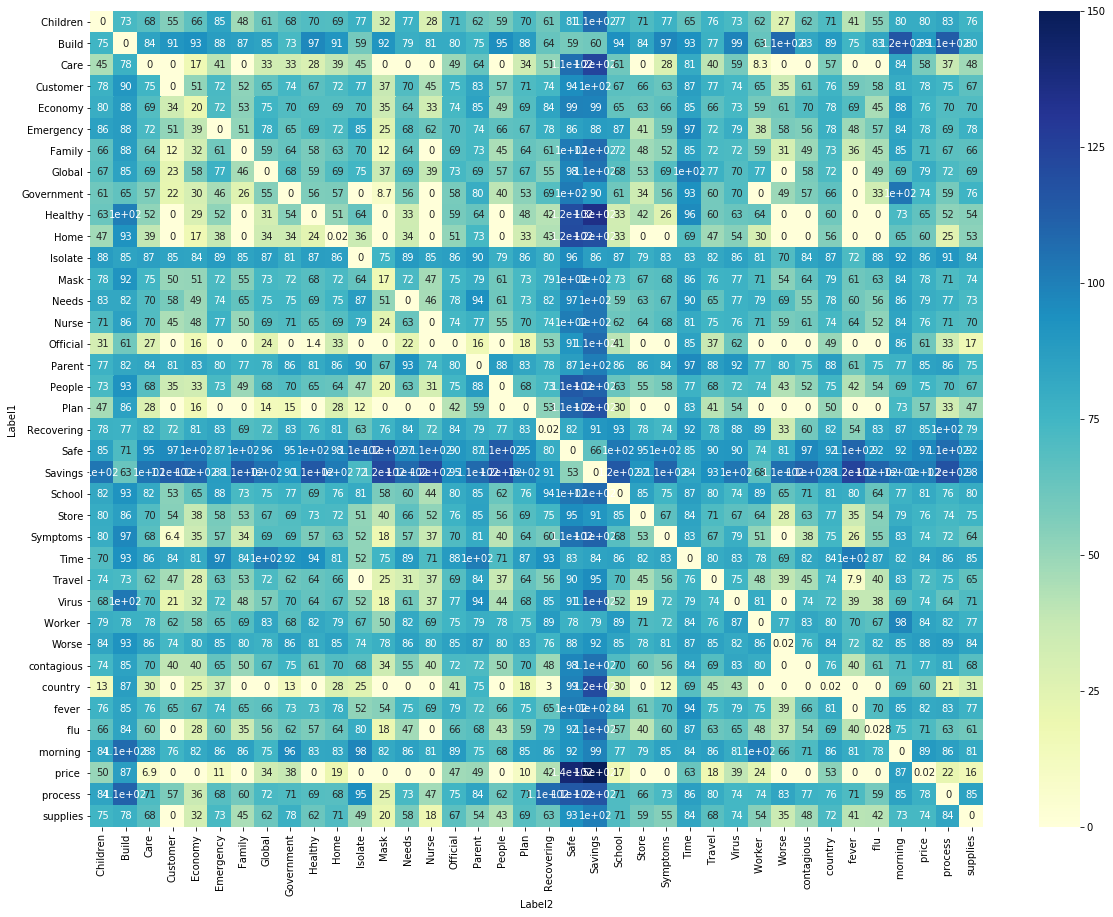

In [55]:
fig, ax = plt.subplots(figsize=(20,15)) 
sns.heatmap(gr.unstack(),annot=True, ax= ax, cmap = "YlGnBu")

In [ ]:
The diagonal represents the same word . Therefore the cosine degree is 0 degrees.

Cosine degree : 0 degree: Similar vectors and exact words.  Nurse and care 0
Cosine degree : 90 degree: Orthogonal vectors and opposite words. Home and worker : 79
Cosine degree : 180 degree: Orthogonal vectors and opposite words.   
        
Dot product value : 1 => Cosine Degree : 0 means Exact Match 
Dot product value : 0 => Cosine Degree : 90 means No Match: Vectors or phrases are orthogonal to each other.
            
The higher the score, the better the model behaves . That means consider the dot product and not cosine degree.

### Stage 3: Hyperparameter Optimization

Step 1: Hyperparameter Tuning - Two Methods for tuning the model to display accurate results. 

Step 2: Analysis of Hyperparameters And Cost Function Scores - Grid Search And Random Search

### Step 1: Hyperparameter Tuning

* Display the hyperparamters of the best model, based on the highest score that String2Vec() function returns.
* The methods in Hyperparameter tuning are Grid Search and Random Search.
* Method 1: Manual Implementation in Grid Search Approach
* Method 2: Manual Implementation in Random Search Approach

Grid Search : Pperates and runs the search over all parameter sets in the grid. Gridearchcv - inbuilt method that can imported from Scikit-learn package.

Random Search :


### Method 1: Manual Approach For Tuning The Model in Grid Search Technique

* Consider Two hyperparameters vector_size, min_alpha and initiate different values.
* Create a model for each set of vector_size, min_alpha value and pass it to String2Vec_grid() function. 
* Identify the hyperparameters vector size and min_aplha of a model that has the highest score 

In [58]:
from sklearn.metrics.pairwise import cosine_similarity
import math

def clean_cos(cos_angle):
    return min(1,max(cos_angle,-1))

def String2vec_grid(data, new_model, Iteration_number):
    
    print("\n Started") 
    model = new_model
    
    res = 0
    vectors = []
    pair_list = []
    cosine_degree = []
    dot_product_score = []

    #to find the vector of a document which is not in training data
    for i in data:
        test_data = word_tokenize(i.lower())
        #print("Tokenized data:  ",test_data)
        vec = model.infer_vector(test_data)  ### here we are using model and calling the test data(which is 50 excel words) 
        vectors.append(vec)
    
    for i in range(len(vectors)):
        for j in range(len(vectors)):
            import math
            vec1 = vectors[i]
            vec2 = vectors[j]
            sim = (np.dot(vec1,vec2) / (np.linalg.norm(vec2) * np.linalg.norm(vec2)))
            # # The dot product divided by the product magnitude of the two vectors
            #print("Similarity of \"{}\" and \"{}\" is {}" .format(data[i],data[j],sim))
            dot_product_score.append(sim)
            
            pair = data[i],data[j]
            pair_list.append(pair)
            
            cos_sim = clean_cos(sim)
            angle_in_radians = math.acos(cos_sim)
            #print("Degrees: ",math.degrees(angle_in_radians))
            cosine_degree.append(math.degrees(angle_in_radians))
    
    print("\n")
    
    # load these values into a dataframe for further analysis.
    df_sentence_scores = pd.DataFrame({'pair': pair_list, 'similarity_degrees': cosine_degree, 'dot_product_score': dot_product_score})
    
    print(df_sentence_scores)
    # Save these values to a dataframe. These are the values for a specifc model with vector Size and alpha value.
    df_sentence_scores.to_excel("Output_Files/grid_search-4-sentence_scores/Iteration-"+str(Iteration_number)+".xlsx", index = False)
    
    # Sume of Squares.
    res = sum(map(lambda i : i * i, dot_product_score))
    
    print("Sum of squares scores: ", res)
    return (res)
            

In [ ]:
# Declaration of empty dataframe.
# Initialize the 3 columns : vector Size, Alpha value, Sum of Squares.

vector_size = [10, 50, 150, 250, 300]
min_alpha = [0.010, 0.025, 0.05, 0.75, 0.1]
df_hyper = pd.DataFrame(columns = ['Vector_Size', 'Min_Alpha', 'Sum_of_Squares'])
max_square = 0
Iteration_number = 0

# Change variable names.
for vec_step in vector_size:
    for aplha in min_alpha:
        new_model = Doc2Vec(tagged_data, vector_size=vec_step, min_alpha= aplha, window=2, min_count=4, workers=5, epochs =10)

        print("\n Iteration", Iteration_number)
        
        sum_of_squares= String2vec_grid(data, new_model, Iteration_number)  # Function call
        
        print("********* Hyperparameter values, sum & Mean metrics for this model are ******** ")
        print("Vector Size: ", vec_step)
        print("min_alpha: ", aplha)
        print("Sum of Squares: ", sum_of_squares)
        
        # load these values into a dataframe for further analysis.
        df_hyper = df_hyper.append({'Vector_Size' : vec_step, 'Min_Alpha' : aplha, 'Sum_of_Squares' : sum_of_squares},  
                ignore_index = True) 
        
        #To find the best parameters for the most accurate model
        if (sum_of_squares >= max_square):
            max_square = sum_of_squares
            vecsize = vec_step
            alpha_value = aplha
            best_iteration_number = Iteration_number
            
        Iteration_number = Iteration_number+1
            
        print("##########  Next loop    ###############")

print("\n Total Iterations Completed: ", Iteration_number) 
print("Best Itertaion Number: ",best_iteration_number )
print("Best sum of squares : ",max_square)
print("Best vec size: ",vecsize)
print("Best Alpha value: ",alpha_value)
print("\n")

# Save the Dataframe to a Excel File.
df_hyper.to_excel("Output_Files/Grid_search-4.xlsx", index = False)

In [ ]:
Total Iterations Completed:  25
Best Itertaion Number:  23
Best sum of squares :  1560996.9315343346
Best vec size:  300
Best Alpha value:  0.75

### Method 2: Manual Implementation For Tuning The Model in Random Search Approach

In [100]:
from sklearn.metrics.pairwise import cosine_similarity
import math

def clean_cos(cos_angle):
    return min(1,max(cos_angle,-1))

def String2vec_random(data, new_model, Iteration_number):
    
    print("\n Started") 
    model = new_model
    
    res = 0
    vectors = []
    pair_list = []
    cosine_degree = []
    dot_product_score = []

    #to find the vector of a document which is not in training data
    for i in data:
        test_data = word_tokenize(i.lower())
        #print("Tokenized data:  ",test_data)
        vec = model.infer_vector(test_data)  ### here we are using model and calling the test data(which is 50 excel words) 
        vectors.append(vec)
    
    for i in range(len(vectors)):
        for j in range(len(vectors)):
            import math
            vec1 = vectors[i]
            vec2 = vectors[j]
            sim = (np.dot(vec1,vec2) / (np.linalg.norm(vec2) * np.linalg.norm(vec2)))
            dot_product_score.append(sim)
            
            pair = data[i],data[j]
            pair_list.append(pair)
            
            cos_sim = clean_cos(sim)
            angle_in_radians = math.acos(cos_sim)
            #print("Degrees: ",math.degrees(angle_in_radians))
            cosine_degree.append(math.degrees(angle_in_radians))

    
    print("\n")
    df_sentence_scores = pd.DataFrame({'pair': pair_list, 'similarity_degrees': cosine_degree, 'dot_product_score': dot_product_score})
    
    print(df_sentence_scores)
    
    df_sentence_scores.to_excel("Output_Files/random_search-2-sentence_scores/Iteration-"+str(Iteration_number)+".xlsx", index = False)
    
    res = sum(map(lambda i : i * i, dot_product_score))
    
    #res = (df_1['dot_product_score'] **2).sum()
    
    print("Sum of squares scores: ", res)   
    return (res)
            

In [ ]:
#list_Size = 5  # list_size = give a user input

import random
df_random_hyper = pd.DataFrame(columns = ['Vector_Size', 'Min_Alpha', 'Sum_of_Squares'])

Iteration_number = 0
max_square = 0
list_Size = int(input("Enter the size of arrays or list:"))

vectorList = random.sample(range(36,45), list_Size)  # step size: 10, 50 range 
print("Randomly generated ineteger vector list is: ",vectorList)

print("\n #### Outer loop Started ####### ")
for step in vectorList:
    
    print("value in Outer loop", step)
    integer_list = random.sample(range(0, 10), list_Size)   # alpha values
    aplhaList = [x/10 for x in integer_list]
    
    print("\n Randomly generated float aplha list is: ", aplhaList)
    
    for val in aplhaList:
        print(" **** Inner alpha loop started  ***")
        print("Vector Size = ", step, "min_alpha = ", val)
        new_model = Doc2Vec(tagged_data, vector_size=step, min_alpha=val, window=2, min_count=4, workers=5, epochs =10)
        print("\n Iteration", Iteration_number)
        
        sum_of_squares= String2vec_random(data, new_model, Iteration_number)  # Function call
        
        print("********* Hyperparameter values, sum & Mean metrics for this model are ******** ")
        print("Vector Size: ", step)
        print("min_alpha: ", val)
        print("Sum of Squares: ", sum_of_squares)
        
        # load these values into a dataframe for further analysis.
        df_random_hyper = df_random_hyper.append({'Vector_Size' : step, 'Min_Alpha' : val, 'Sum_of_Squares' : sum_of_squares},  
                ignore_index = True) 
        
        #To find the best parameters for the most accurate model
        if (sum_of_squares >= max_square):
            max_square = sum_of_squares
            vecsize = step
            alpha_value = val
            best_iteration_number = Iteration_number
        
        Iteration_number = Iteration_number+1
        
        print("##########  Next loop    ###############")
        
    
    print(" **** END of inner aplha loop *** ")
    
print("\n #### Outer loop Ended #######")

print("\n Total Iterations Completed: ",Iteration_number ) 

print("Best Itertaion Number: ",best_iteration_number )
print("Best sum of squares : ",max_square)
print("Best vec size: ",vecsize)
print("Best Alpha value: ",alpha_value)
print("\n")

# Save the Dataframe to a Excel File.
df_random_hyper.to_excel("Output_Files/random_search-2.xlsx", index = False)

### Step 6: Analysis of Hyperparameters And Cost Function Scores

### Vizulisations on Grid Search Analysis

In [65]:
df_grid_hyperparam = pd.read_excel("Output_Files/Grid_search-4.xlsx")

In [64]:
# This is in scientific notation.
df_grid_hyperparam

,Vector_Size,Min_Alpha,Sum_of_Squares
0,10,0.010,1.231182e+03
1,10,0.025,1.189386e+03
2,10,0.050,8.446356e+02
3,10,0.750,5.835076e+05
4,10,0.100,5.220441e+02
5,50,0.010,4.808384e+02
6,50,0.025,4.570157e+02
7,50,0.050,3.657790e+02
8,50,0.750,6.505014e+05
9,50,0.100,3.346342e+02


In [66]:
# convert from scientific to float
df_grid_hyperparam["Sum_of_Squares"] = df_grid_hyperparam["Sum_of_Squares"].apply(lambda x: format(x, 'f'))
df_grid_hyperparam

,Vector_Size,Min_Alpha,Sum_of_Squares
0,10,0.010,1231.181623
1,10,0.025,1189.386139
2,10,0.050,844.635643
3,10,0.750,583507.571344
4,10,0.100,522.044088
5,50,0.010,480.838441
6,50,0.025,457.015705
7,50,0.050,365.778988
8,50,0.750,650501.432952
9,50,0.100,334.634206


In [67]:
df_grid_hyperparam['Sum_of_Squares'].describe()

count             25
unique            25
top       343.799565
freq               1
Name: Sum_of_Squares, dtype: object

In [69]:
df_grid_hyperparam.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 3 columns):
Vector_Size       25 non-null int64
Min_Alpha         25 non-null float64
Sum_of_Squares    25 non-null object
dtypes: float64(1), int64(1), object(1)
memory usage: 680.0+ bytes


In [70]:
df_grid_hyperparam.Sum_of_Squares.dtype

dtype('O')

In [71]:
# convert Object data type to numeric data type.
df_grid_hyperparam['Sum_of_Squares'] = df_grid_hyperparam["Sum_of_Squares"].apply(pd.to_numeric, errors='coerce')

In [72]:
df_grid_hyperparam.Sum_of_Squares.dtype

dtype('float64')

### Histogram : Sum of Squares 

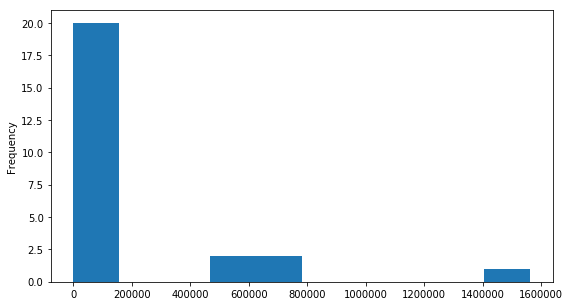

In [73]:
plt.figure(figsize = (9, 5)) 
df_grid_hyperparam['Sum_of_Squares'].plot(kind ="hist") 

# A frequency distribution shows how often each different value in a set of data occurs

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a46cf6160>,
      dtype=object)

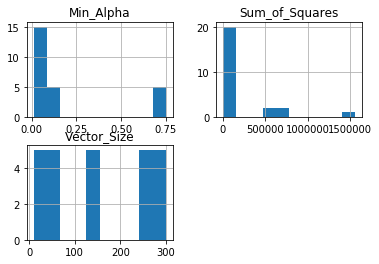

In [74]:
df_grid_hyperparam.hist()

In [81]:
# Plot the hyperparameters against the sum of squares value.
# correlation between variables.
df_grid_hyperparam.corr()

,Vector_Size,Min_Alpha,Sum_of_Squares
Vector_Size,1.000000,0.000000,0.151369
Min_Alpha,0.000000,1.000000,0.882789
Sum_of_Squares,0.151369,0.882789,1.000000


### Annotated Heat Map of a Grid Correlation Matrix

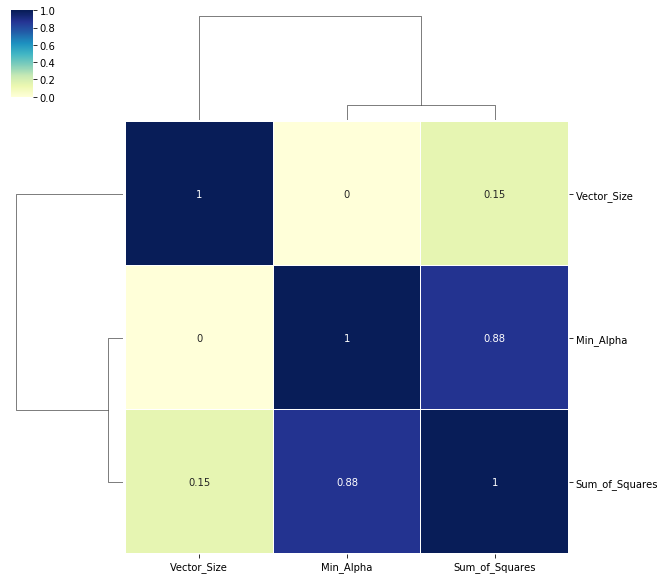

In [83]:
# https://www.geeksforgeeks.org/exploring-correlation-in-python/
corrmatrix = df_grid_hyperparam.corr() 
cg = sns.clustermap(corrmatrix, cmap ="YlGnBu", linewidths = 0.1, annot=True)
plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation = 0)   
cg 

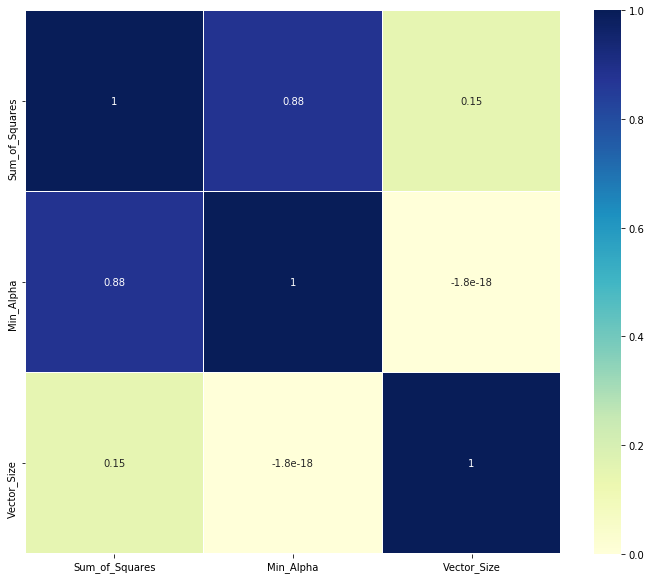

In [84]:
# sumofsquares correlation matrix 
# k : number of variables for heatmap 
k = 5 
cols = corrmatrix.nlargest(k, 'Sum_of_Squares')['Sum_of_Squares'].index 
  
cm = np.corrcoef(df_grid_hyperparam[cols].values.T) 
f, ax = plt.subplots(figsize =(12, 10)) 
  
sns.heatmap(cm, ax = ax, cmap ="YlGnBu", annot=True,
            linewidths = 0.1, yticklabels = cols.values,  
                              xticklabels = cols.values) 

#### Explanation:

-1: perfect negative linear correlation
+1:perfect positive linear correlation and 
0: No correlation

When the data points follow a roughly straight-line trend, the variables are said to have an approximately linear relationship.

Denoted by r, it takes values between -1 and +1
A positive value for r indicates a positive association, and a negative value for r indicates a negative association.
The closer r is to 1 the closer the data points fall to a straight line, thus, the linear association is stronger. The closer r is to 0, making the linear association weaker.

As the Min_alpha and sum_of_squares has the value 0.93 that is closer to 1, denotes the linear association is stronger and tends to have a positive corelation.
Whereas vector_size and sum_of_squares has the value 0.15 that is closer to 0, denotes the linear association is weaker and tends to have a negative corelation.



### Visualizations on Random Search Analysis

In [90]:
df_random_hyperparam = pd.read_excel("Output_Files/random_search-1.xlsx")

In [91]:
df_random_hyperparam["Sum_of_Squares"].describe().apply(lambda x: format(x, 'f'))

count         25.000000
mean      472381.002463
std       684788.972135
min          338.713689
25%          770.922163
50%       210222.794083
75%       560843.664644
max      2510239.461492
Name: Sum_of_Squares, dtype: object

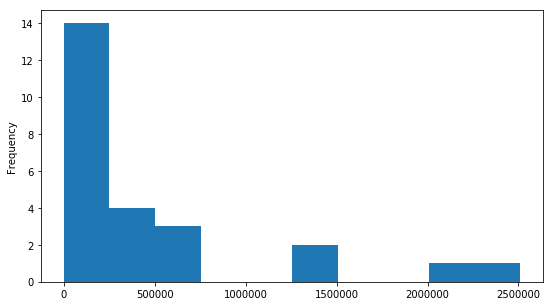

In [92]:
# A frequency distribution shows how often each different value in a set of data occurs
plt.figure(figsize = (9, 5)) 
df_random_hyperparam['Sum_of_Squares'].plot(kind ="hist") 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a43b41e80>,
      dtype=object)

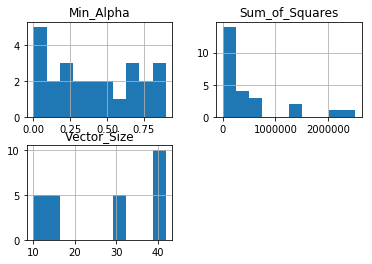

In [93]:
df_random_hyperparam.hist()

### Sample Vector Size within range of 10 to 40

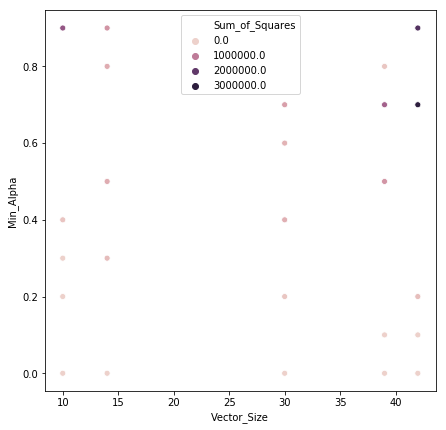

In [95]:
# Show groups with different colors using "hue"
plt.figure(figsize=(7,7))
sns.scatterplot(x=df_random_hyperparam.Vector_Size , y=df_random_hyperparam.Min_Alpha , hue=df_random_hyperparam.Sum_of_Squares)
plt.show()

### Vector Size within smaller samples between 36 to 45

In [105]:
#df_random_smaller_steps = pd.read_excel("Output_Files/random_search-2.xlsx")
df_random_smaller_steps.head()

,Vector_Size,Min_Alpha,Sum_of_Squares
0,36,0.7,3.983566e+05
1,36,0.8,1.300450e+06
2,36,0.2,7.373119e+04
3,36,0.0,5.935945e+02
4,36,0.9,2.411589e+06


In [107]:
df_random_smaller_steps["Sum_of_Squares"].describe().apply(lambda x: format(x, 'f'))

count         25.000000
mean      549328.014082
std       606346.191130
min          327.754048
25%        78099.789141
50%       359973.539393
75%       619308.355076
max      2411588.734560
Name: Sum_of_Squares, dtype: object

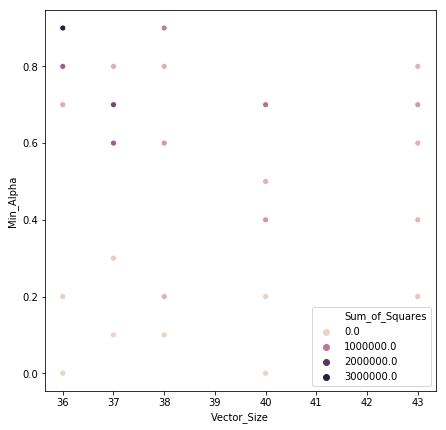

In [108]:
# Show groups with different colors using "hue"
plt.figure(figsize=(7,7))
sns.scatterplot(x=df_random_smaller_steps.Vector_Size , y=df_random_smaller_steps.Min_Alpha , hue=df_random_smaller_steps.Sum_of_Squares)
plt.show()

* The Model resulted higher scores within the vector range of 36 to 38. 



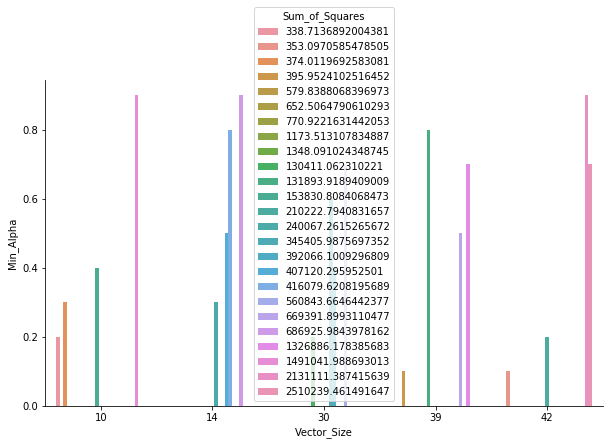

In [96]:
# Show groups with different colors using "hue"
plt.figure(figsize=(10,6))
sns.barplot(x=df_random_hyperparam.Vector_Size , y=df_random_hyperparam.Min_Alpha , hue=df_random_hyperparam.Sum_of_Squares)
sns.despine()
plt.show()

In [97]:
# Plot the hyperparameters against the sum of squares value.
# correlation between variables.
df_random_hyperparam.corr()

,Vector_Size,Min_Alpha,Sum_of_Squares
Vector_Size,1.000000,-0.036062,0.239107
Min_Alpha,-0.036062,1.000000,0.691438
Sum_of_Squares,0.239107,0.691438,1.000000


In [ ]:
# sumofsquares correlation matrix 
# k : number of variables for heatmap 
k = 5 
cols = corrmatrix.nlargest(k, 'Sum_of_Squares')['Sum_of_Squares'].index 
  
cm = np.corrcoef(df_random_hyperparam[cols].values.T) 
f, ax = plt.subplots(figsize =(12, 10)) 
  
sns.heatmap(cm, ax = ax, cmap ="Greens", annot=True,
            linewidths = 0.1, yticklabels = cols.values,  
                              xticklabels = cols.values) 


As the Min_alpha and sum_of_squares has the value 0.69 that is a bit closer to 1, denotes the linear association is medium stronger and tends to have a medium positive corelation.

Whereas vector_size and sum_of_squares has the value 0.24 that is closer to 0, denotes the linear association is weaker and tends to have a negative corelation.

### Stage 4: Topic Modelling

It is a process to automatically identify topics present in a text object and to derive hidden patterns exhibited by a text corpus. Thus, assisting better decision making.

Topic Modelling is different from rule-based text mining approaches that use regular expressions or dictionary based keyword searching techniques. It is an unsupervised approach used for finding and observing the bunch of words (called “topics”) in large clusters of texts.

* Latent Dirichlet Allocation for Topic Modeling: There are many approaches for obtaining topics from a text such as – Term Frequency and Inverse Document Frequency. NonNegative Matrix Factorization techniques. Latent Dirichlet Allocation is the best approach for topic modeling technique.

#### LDA Analysis For Topic Modelling
    * Plot The frequent words
    * Add POS TAGS For Lemmatized Tokens 
    * create doc_term_matrix from corpus dictionary
    * Implement LDA approach to retrieve the topics
    * Use pyLDAvis for Vizulizations

In [1]:
# Function to plot most frequent terms
def freq_words(x, terms = 30):
    all_words = ' '.join([text for text in x])
    all_words = all_words.split()

    fdist = FreqDist(all_words)
    words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})

    # selecting top 20 most frequent words
    d = words_df.nlargest(columns="count", n = terms) 
    plt.figure(figsize=(20,5))
    ax = sns.barplot(data=d, x= "word", y = "count")
    ax.set(ylabel = 'Count')
    plt.show()

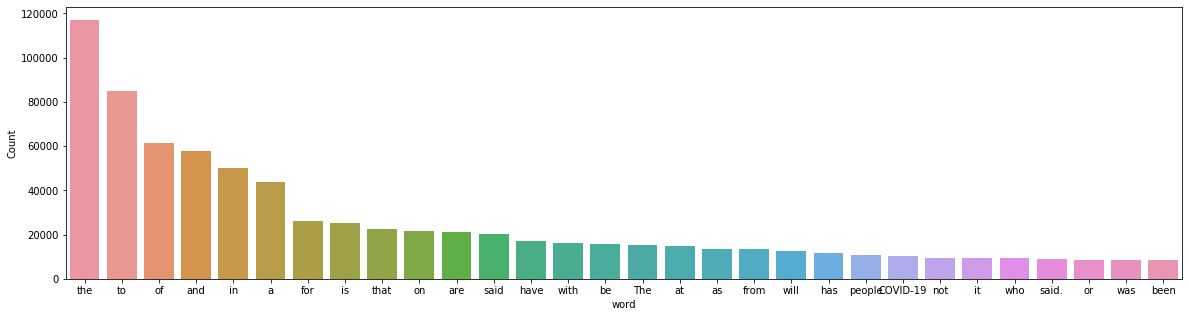

In [17]:
freq_words(df['text'])

In [35]:
df['body_text_nostop'] = df['body_text_tokenized'].apply(lambda x: remove_stopwords(x))

In [36]:
# remove unwanted characters, numbers and symbols
df['text'] = df['text'].str.replace("[^a-zA-Z#]", " ")

# function to remove stopwords
def remove_stopwords(rev):
    rev_new = " ".join([i for i in rev if i not in stopword])
    return rev_new

# remove short words (length < 3)
df['text'] = df['text'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))

# remove stopwords from the text
wordsText = [remove_stopwords(r.split()) for r in df['text']]

# make entire text lowercase
wordsText = [r.lower() for r in wordsText]

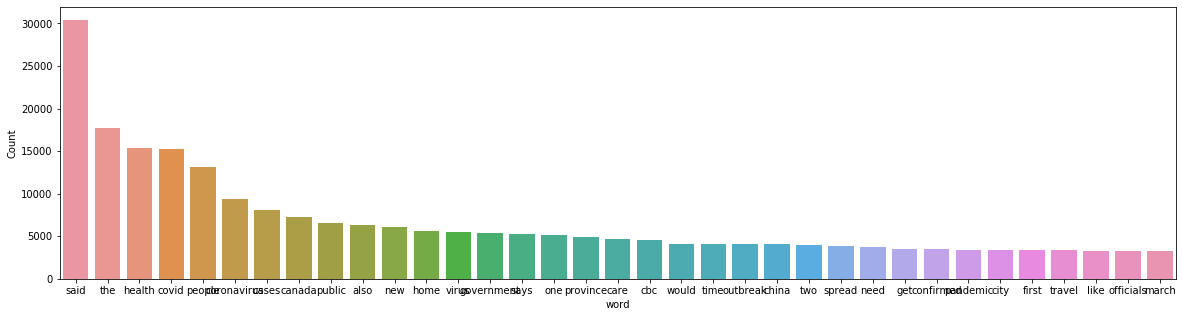

In [37]:
freq_words(wordsText, 35)

In [38]:
nlp = spacy.load('en', disable=['parser', 'ner'])

def lemmatization(texts, tags=['NOUN', 'ADJ']): # filter noun and adjective
    output = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        output.append([token.lemma_ for token in doc if token.pos_ in tags])
    return output

In [39]:
tokenized_wordsText = pd.Series(wordsText).apply(lambda x: x.split())
print(tokenized_wordsText[1])

['the', 'yukon', 'government', 'identified', 'two', 'places', 'whitehorse', 'church', 'dental', 'clinic', 'people', 'may', 'exposed', 'coronavirus', 'recent', 'weeks', 'news', 'release', 'thursday', 'evening', 'government', 'said', 'anybody', 'went', 'either', 'place', 'certain', 'days', 'monitor', 'symptoms', 'may', 'indicate', 'covid', 'fever', 'cough', 'difficulty', 'breathing', 'days', 'call', 'symptoms', 'develop', 'the', 'possible', 'sources', 'exposure', 'sunday', 'morning', 'services', 'bethany', 'church', 'alaska', 'highway', 'march', 'march', 'church', 'kids', 'zone', 'march', 'elias', 'dental', 'clinic', 'march', 'march', 'according', 'news', 'release', 'places', 'visited', 'dates', 'person', 'persons', 'tested', 'positive', 'covid', 'also', 'says', 'people', 'attended', 'places', 'identified', 'times', 'need', 'self', 'isolate', 'long', 'remain', 'healthy', 'develop', 'symptoms', 'the', 'risk', 'individuals', 'possible', 'exposures', 'low', 'release', 'says', 'bethany', 'ch

In [40]:
wordsText_2 = lemmatization(tokenized_wordsText)
print(wordsText_2[1]) # print lemmatized review

['government', 'place', 'whitehorse', 'church', 'dental', 'clinic', 'people', 'coronavirus', 'recent', 'week', 'release', 'evening', 'government', 'certain', 'day', 'symptom', 'covid', 'fever', 'cough', 'difficulty', 'breathing', 'day', 'symptom', 'possible', 'source', 'exposure', 'morning', 'news', 'release', 'place', 'person', 'person', 'positive', 'covid', 'people', 'place', 'time', 'self', 'isolate', 'healthy', 'develop', 'symptom', 'risk', 'possible', 'exposure', 'low', 'release', 'church', 'positive', 'covid', 'morning', 'church', 'case', 'covid', 'health', 'official', 'case', 'couple', 'whitehorse', 'third', 'person', 'community', 'residential', 'eviction', 'sick', 'leave', 'pandemiccovid', 'centre', 'whitehorse', 'person', 'people', 'dental', 'home', 'government', 'news', 'release', 'ongoing', 'risk', 'community', 'church', 'clinic']


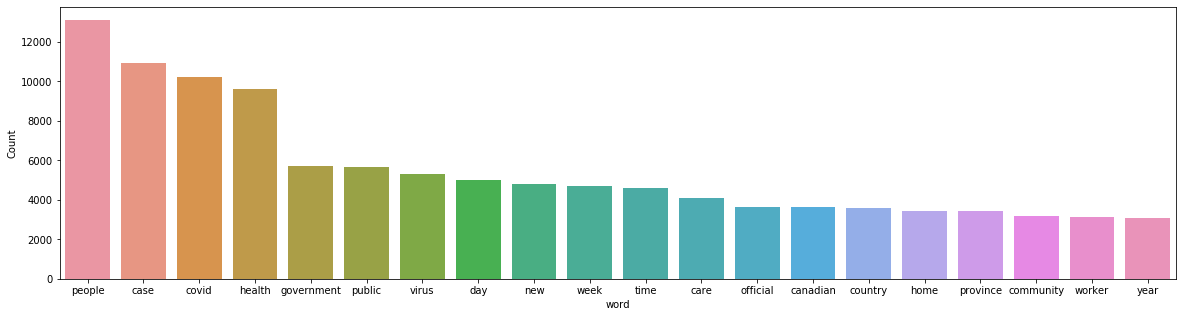

In [41]:
wordsText_3 = []
for i in range(len(wordsText_2)):
    wordsText_3.append(' '.join(wordsText_2[i]))

df['wordsText'] = wordsText_3

freq_words(df['wordsText'], 20)

In [42]:
dictionary = corpora.Dictionary(wordsText_2)

In [43]:
doc_term_matrix = [dictionary.doc2bow(rev) for rev in wordsText_2]

In [44]:
# Creating the object for LDA model using gensim library
LDA = gensim.models.ldamodel.LdaModel

# Build LDA model
lda_model = LDA(corpus=doc_term_matrix, id2word=dictionary, num_topics=10, random_state=100,
                chunksize=1000, passes=50)

In [45]:
lda_model.print_topics()

[(0,
  '0.052*"student" + 0.052*"school" + 0.020*"child" + 0.018*"class" + 0.016*"parent" + 0.013*"week" + 0.012*"family" + 0.011*"covid" + 0.010*"online" + 0.010*"time"'),
 (1,
  '0.041*"case" + 0.040*"virus" + 0.026*"people" + 0.021*"health" + 0.018*"new" + 0.017*"country" + 0.015*"outbreak" + 0.014*"death" + 0.012*"infection" + 0.012*"official"'),
 (2,
  '0.012*"year" + 0.010*"time" + 0.009*"government" + 0.009*"event" + 0.008*"election" + 0.007*"party" + 0.007*"people" + 0.006*"new" + 0.006*"leader" + 0.006*"good"'),
 (3,
  '0.020*"animal" + 0.018*"information" + 0.013*"trump" + 0.011*"people" + 0.011*"human" + 0.010*"dog" + 0.009*"datum" + 0.008*"pet" + 0.007*"medium" + 0.007*"social"'),
 (4,
  '0.060*"case" + 0.031*"health" + 0.031*"covid" + 0.023*"people" + 0.021*"symptom" + 0.021*"public" + 0.016*"self" + 0.014*"official" + 0.013*"day" + 0.013*"positive"'),
 (5,
  '0.022*"price" + 0.020*"cent" + 0.019*"market" + 0.018*"oil" + 0.018*"year" + 0.015*"budget" + 0.014*"economy" + 0.

In [46]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, doc_term_matrix, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6     -0.095107 -0.025408       1        1  21.304951
4     -0.235044  0.048087       2        1  14.009692
8      0.005936 -0.028503       3        1  12.150649
1     -0.140840  0.131924       4        1  11.908780
9     -0.062782 -0.037420       5        1   9.233412
2      0.109816 -0.034014       6        1   9.044305
7      0.060072 -0.153553       7        1   7.984682
5      0.150990 -0.085471       8        1   7.183886
0      0.018426 -0.096371       9        1   5.224026
3      0.188533  0.280729      10        1   1.955610, topic_info=          Term          Freq         Total Category  logprob  loglift
83        case  10531.000000  10531.000000  Default  30.0000  30.0000
545     school   2281.000000   2281.000000  Default  29.0000  29.0000
1174   student   1958.000000   1958.000000  Default  28.0000  28.0000
78       virus   5207.000000   5207.000000  Default  27.0000  27.0000
142   business   2700.000000   2700.000000  Default  26.0000  26.0000
...        ...           ...           ...      ...      ...      ...
156     crisis     67.811142   1025.516846  Topic10  -5.3058   1.2182
66    response     68.673904   1379.144287  Topic10  -5.2932   0.9346
14       covid     85.774361  10199.893555  Topic10  -5.0708  -0.8439
9     canadian     61.257298   3623.004395  Topic10  -5.4075  -0.1455
289        way     58.540009   1667.168701  Topic10  -5.4528   0.5853

[769 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
3254      4  0.089435        academic
3254      9  0.894345        academic
5294      6  0.971931        activist
3614      1  0.980174       addiction
1596      3  0.099283  administration
...     ...       ...             ...
855       3  0.176051           young
855       5  0.088025           young
855       6  0.492467           young
855       9  0.149881           young
5961      1  0.972490         yukoner

[2029 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 5, 9, 2, 10, 3, 8, 6, 1, 4])

### End of code

#### References:

https://en.wikipedia.org/wiki/Hyperparameter_optimization

https://www.jeremyjordan.me/hyperparameter-tuning/

https://stackoverflow.com/questions/32401493/how-to-create-customize-your-own-scorer-function-in-scikit-learn

https://medium.com/@mandava807/cross-validation-and-hyperparameter-tuning-in-python-65cfb80ee485

https://campus.datacamp.com/courses/hyperparameter-tuning-in-python/hyperparameters-and-parameters?ex=1

https://stackoverflow.com/questions/47890052/improving-gensim-doc2vec-results

https://github.com/jhlau/doc2vec

https://radimrehurek.com/gensim/models/doc2vec.html

https://medium.com/@mishra.thedeepak/doc2vec-simple-implementation-example-df2afbbfbad5

https://gist.github.com/lgallen/8c2404bf6227c772faef40e423aa5007

https://pynative.com/python-random-randrange/

https://thorbenschlaetzer.de/Projects/Applivo/Text_Feature_Extraction_Pipeline/

https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/
    
Grid_search: Run a function iteratively using a grid search approach - Automation Works in R script 
https://rdrr.io/cran/paramtest/man/grid_search.html

Feed paramters to the scoring function
https://stackoverflow.com/questions/38064637/pass-estimator-to-custom-score-function-via-sklearn-metrics-make-scorer
